# War fatalities in Russia in 2022--2023 estimated via excess male mortality
## External deaths by gender

In [1]:
%matplotlib inline

import numpy as np
import pylab as plt
import pandas as pd

from sklearn.linear_model import LinearRegression

plt.style.use("mpl_style.txt")

In [2]:
df_external = pd.read_excel('../external-deaths-by-gender-year/external-deaths.xlsx', skiprows=1)

df_external

,Unnamed: 0,Мужчины и женщины,Мужчины,Женщины
0,2000,318716,250009,68707
1,2001,331634,259109,72525
2,2002,339296,264055,75241
3,2003,335173,260323,74850
4,2004,327123,254109,73014
5,2005,315915,246257,69658
6,2006,282785,219216,63569
7,2007,259412,201334,58078
8,2008,244463,189552,54911
9,2009,224576,173089,51487


In [3]:
df_external_2023 = pd.read_excel('../external-deaths-by-gender-year/external-deaths-2023.xlsx', skiprows=1)

df_external_2023

,Unnamed: 0,Мужчины и женщины,Мужчины,Женщины
0,Российская Федерация,156736,127567,29169
1,Центральный федеральный округ,36066,28988,7078
2,Белгородская область,1430,1183,247
3,Брянская область,1576,1311,265
4,Владимирская область,1525,1230,295
...,...,...,...,...
91,Амурская область,1561,1265,296
92,Магаданская область,254,204,50
93,Сахалинская область,923,790,133
94,Еврейская автономная область,237,205,32


In [4]:
male = df_external.values[:,2]
female = df_external.values[:,3]

male = np.concatenate((male, df_external_2023.values[0, 2:3].astype(int)))
female = np.concatenate((female, df_external_2023.values[0, 3:4].astype(int)))

years = np.arange(2000, 2024)

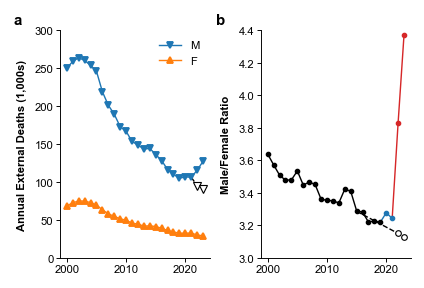

In [5]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(3, 2))

axs[0].plot(years, male / 1000, 'v-', label='M', markersize=3)
axs[0].plot(years, female / 1000, '^-', label='F', markersize=3)
axs[0].set_ylim([0, 300])
axs[0].set_ylabel('Annual External Deaths (1,000s)', fontweight="bold")
axs[0].legend()
axs[0].set_title(" ")

ratio = male / female

axs[1].plot(years[:-4], ratio[:-4], 'k.-')
axs[1].plot(years[-5:-2], ratio[-5:-2], '-', color='tab:blue', zorder=-1)
axs[1].plot(years[-4:-2], ratio[-4:-2], '.', color='tab:blue')
axs[1].plot(years[-3:], ratio[-3:], '-', color='tab:red', zorder=-1)
axs[1].plot(years[-2], ratio[-2], '.', color='tab:red', clip_on=False)
axs[1].plot(years[-1], ratio[-1], '.', color='tab:red', clip_on=False)

axs[1].set_ylim([3, 4.4])
axs[1].set_ylabel(r'Male/Female Ratio', fontweight="bold")
axs[1].set_title(" ")

# Do computations
x = np.arange(2015, 2024)
LinReg = LinearRegression()
LinReg.fit(x[-9:-4].reshape(-1,1), ratio[-9:-4].reshape(-1,1))
yhat = LinReg.predict(x[-9:].reshape(-1,1))
baseline22 = yhat[-2,0] * female[-2] / 1000
baseline23 = yhat[-1,0] * female[-1] / 1000

axs[0].plot(x[-3:], [male[-3]/1000, baseline22, baseline23], '--', color='k', zorder=-2)
axs[0].plot(x[-2], baseline22, 'v', color='w', markeredgecolor='k', 
            markersize=4, markeredgewidth=.6, zorder=-2, clip_on=False)
axs[0].plot(x[-1], baseline23, 'v', color='w', markeredgecolor='k', 
            markersize=4, markeredgewidth=.6, zorder=-2, clip_on=False)

axs[1].plot(x[-9:], yhat, '--', color='k', zorder=-2)
axs[1].plot(x[-2], yhat[-2], 'o', color='w', markeredgecolor='k', 
            markersize = 3, markeredgewidth=.6, zorder=-2, clip_on=False)
axs[1].plot(x[-1], yhat[-1], 'o', color='w', markeredgecolor='k', 
            markersize = 3, markeredgewidth=.6, zorder=-2, clip_on=False)

fig.text(.005, .95, 'a', fontsize=8, weight='bold')
fig.text(.505, .95, 'b', fontsize=8, weight='bold')

fig.savefig('figures/external-gender.png')
fig.savefig('figures/external-gender.pdf')

In [6]:
for fit_length in [5, 10]:
    x = years
    beg = fit_length + 4

    # Perform the linear fit and extrapolate
    LinReg.fit(x[-beg:-4].reshape(-1,1), ratio[-beg:-4].reshape(-1,1))
    yhat_sklearn = LinReg.predict(x[-beg:].reshape(-1,1))
    excess = male[-2:] - yhat_sklearn[-2:][0] * female[-2:]

    # Compute the uncertainty
    X = np.concatenate((x[-beg:].reshape(-1,1), np.ones((beg,1))), axis=1)
    y = ratio[-beg:].reshape(-1,1)
    beta = np.linalg.pinv(X[-beg:-4].T @ X[-beg:-4]) @ X[-beg:-4].T @ y[-beg:-4]
    yhat = X[-beg:] @ beta
    sigma2 = np.sum((y[-beg:-4] - yhat[-beg:-4])**2) / (y[-beg:-4].size - 2) # sigma^2 = MSE/(n-p)
    S = np.linalg.pinv(X[-beg:-4].T @ X[-beg:-4])
    predictive_var = sigma2 * X[-2:] @ S @ X[-2:].T + sigma2
    predictive_std = np.sqrt(np.diag(predictive_var))
    excess_std = predictive_std * female[-2:]

    assert(np.allclose(yhat, yhat_sklearn))

    print(f'Excess 2022 (based on {fit_length:2}-year trend): {excess[0]:.0f} +- {excess_std[0]:.0f}')
    print(f'Excess 2023 (based on {fit_length:2}-year trend): {excess[1]:.0f} +- {excess_std[1]:.0f}')
    print('')

Excess 2022 (based on  5-year trend): 20562 +- 1084
Excess 2023 (based on  5-year trend): 35666 +- 1192

Excess 2022 (based on 10-year trend): 20095 +- 2025
Excess 2023 (based on 10-year trend): 35216 +- 2057

